In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from datetime import datetime
import pandas as pd
import numpy as np
import random
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
INPUT_LENGTH = 50000
LATENT_DIM = 1024
LEARNING_RATE = 0.001
EPOCH = 50
BATCH_SIZE = 16

In [ ]:
import pickle
with open(r'/content/drive/MyDrive/spellcheck/encoder_tokenizer.pickle', 'rb') as handle:
    encoder_tokenizer = pickle.load(handle)
with open(r'/content/drive/MyDrive/spellcheck/decoder_tokenizer.pickle', 'rb') as handle:
    decoder_tokenizer = pickle.load(handle)

In [ ]:
# encoder_tokenizer = tf.keras.preprocessing.text.Tokenizer(
#     # num_words=NUM_WORDS,
#     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
#     lower=True,
#     char_level=True
# )

# decoder_tokenizer = tf.keras.preprocessing.text.Tokenizer(
#     # num_words=NUM_WORDS,
#     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
#     lower=True,
#     char_level=True
# )

In [ ]:
wiki = pd.read_csv("/content/drive/MyDrive/spellcheck/wiki_root.csv", header=0, sep=";")
grams3 = pd.read_csv("/content/drive/MyDrive/spellcheck/all_3grams.csv", header=0, sep=";")
df = pd.read_csv("/content/drive/MyDrive/spellcheck/26-12/train1.csv", header=0, sep=";")
val_data = pd.read_csv("/content/drive/MyDrive/spellcheck/val_set.csv", sep=";")

In [ ]:
print(df.shape)
print(wiki.shape)
print(grams3.shape)
print(val_data.shape)

(16746, 2)
(14594, 2)
(238610, 2)
(4797, 2)


In [ ]:
# df = df.sample(frac=0.5)
# df = pd.concat([df.sample(frac=0.5), wiki.sample(10000), grams3.sample(5000)])

In [ ]:
val_data = val_data[:1000]

In [ ]:
df

,replaced,initial
0,gidiyo,gidiyor
1,bahset,bahset
2,bahsedilme,bahsedilme
3,soğutma,soğutma
4,film,film
...,...,...
16741,değiştirilemeyeceği,değiştirilemeyeceği
16742,istikrarsızlaştıran,istikrarsızlaştıran
16743,getirilemeyeceğinin,getirilemeyeceğinin
16744,sergileyememektedir,sergileyememektedir


In [ ]:
!pip install Levenshtein
import Levenshtein

def calculate_levenshtein_distance(row, column_names=["initial","replaced"]):
  return Levenshtein.distance(str(row[column_names[0]]), str(row[column_names[1]]))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 17.3 MB/s eta 0:00:00


In [ ]:
df

,replaced,initial
0,gidiyo,gidiyor
1,bahset,bahset
2,bahsedilme,bahsedilme
3,soğutma,soğutma
4,film,film
...,...,...
16741,değiştirilemeyeceği,değiştirilemeyeceği
16742,istikrarsızlaştıran,istikrarsızlaştıran
16743,getirilemeyeceğinin,getirilemeyeceğinin
16744,sergileyememektedir,sergileyememektedir


In [ ]:
df["type"] = df['replaced'].apply(type)
df = df[df["type"] != float]

val_data["type"] = val_data['typos'].apply(type)
val_data = val_data[val_data["type"] != float]

In [ ]:
df['distance'] = df.apply(calculate_levenshtein_distance, axis=1)
val_data['distance'] = val_data.apply(lambda x: calculate_levenshtein_distance(x, column_names=["typos", "corrected"]), axis=1)

In [ ]:
print(df.distance.unique())
print(val_data.distance.unique())

[1 0 2 3]
[1]


In [ ]:
distance_counts = df['distance'].value_counts()
distance_counts

0    8328
1    8234
2     182
3       2
Name: distance, dtype: int64

In [ ]:
df[df["distance"] > 2]

,replaced,initial,type,distance
273,istyrm,istiyorum,<class 'str'>,3
446,komşularımızd,komuşlarımızda,<class 'str'>,3


In [ ]:
# df[df['distance'] == 2]

In [ ]:
df = df[df["distance"] < 3]

In [ ]:
df

,replaced,initial,type,distance
0,gidiyo,gidiyor,<class 'str'>,1
1,bahset,bahset,<class 'str'>,0
2,bahsedilme,bahsedilme,<class 'str'>,0
3,soğutma,soğutma,<class 'str'>,0
4,film,film,<class 'str'>,0
...,...,...,...,...
16741,değiştirilemeyeceği,değiştirilemeyeceği,<class 'str'>,0
16742,istikrarsızlaştıran,istikrarsızlaştıran,<class 'str'>,0
16743,getirilemeyeceğinin,getirilemeyeceğinin,<class 'str'>,0
16744,sergileyememektedir,sergileyememektedir,<class 'str'>,0


In [ ]:
df["encoder_input"] = df["replaced"]
df["decoder_input"] = "<" + df["initial"]
df["decoder_output"] = df["initial"] + ">"
df = df[["encoder_input","decoder_input", "decoder_output"]]
#df = df.drop(["initial","replaced"], axis=1)

val_data["encoder_input"] = val_data["typos"]
val_data["decoder_input"] = "<" + val_data["corrected"]
val_data["decoder_output"] = val_data["corrected"] + ">"
val_data = val_data[["encoder_input", "decoder_input", "decoder_output"]]

# ============================
df = df.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)

In [ ]:
df["type"] = df['encoder_input'].apply(type)
df = df[df["type"] != float]
df = df[["encoder_input", "decoder_input", "decoder_output"]]

val_data["type"] = val_data['encoder_input'].apply(type)
val_data = val_data[val_data["type"] != float]
val_data = val_data[["encoder_input", "decoder_input", "decoder_output"]]

df = df[(df['encoder_input'].apply(len) >= 4) & (df['decoder_input'].apply(len) < 20 ) & (df['decoder_output'].apply(len) >= 5)]
val_data = val_data[(val_data['encoder_input'].apply(len) >= 4) & (val_data['decoder_input'].apply(len) < 20 ) & (val_data['decoder_output'].apply(len) >= 5) & (val_data['decoder_output'].apply(len) < 20)]

In [ ]:
df = df.reset_index(drop=True)
df

,encoder_input,decoder_input,decoder_output
0,gidiyo,<gidiyor,gidiyor>
1,bahset,<bahset,bahset>
2,bahsedilme,<bahsedilme,bahsedilme>
3,soğutma,<soğutma,soğutma>
4,film,<film,film>
...,...,...,...
15738,seyredebilmektedir,<seyredebilmektedir,seyredebilmektedir>
15739,noktalayacaklarını,<noktalayacaklarını,noktalayacaklarını>
15740,olgunlaştırılmadan,<olgunlaştırılmadan,olgunlaştırılmadan>
15741,yararlanılmaktadır,<yararlanılmaktadır,yararlanılmaktadır>


In [ ]:
input_lengths = df['encoder_input'].apply(len)
output_lengths = df['decoder_output'].apply(len)

print("Max input length: ", max(input_lengths))
print("Max output length: ", max(output_lengths))

print("Min input length: ", min(input_lengths))
print("Min output length: ", min(output_lengths))

print("==================================")
val_data_input_lengths = val_data['encoder_input'].apply(len)
val_data_output_lengths = val_data['decoder_output'].apply(len)

print("Val data Max input length: ", max(val_data_input_lengths))
print("Val data Max output length: ", max(val_data_output_lengths))

print("Val data Min input length: ", min(val_data_input_lengths))
print("Val data Min output length: ", min(val_data_output_lengths))

df = df.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)
df

Max input length:  19
Max output length:  19
Min input length:  4
Min output length:  5
Val data Max input length:  19
Val data Max output length:  19
Val data Min input length:  4
Val data Min output length:  5


,encoder_input,decoder_input,decoder_output
0,gidiyo,<gidiyor,gidiyor>
1,bahset,<bahset,bahset>
2,bahsedilme,<bahsedilme,bahsedilme>
3,soğutma,<soğutma,soğutma>
4,film,<film,film>
...,...,...,...
15738,seyredebilmektedir,<seyredebilmektedir,seyredebilmektedir>
15739,noktalayacaklarını,<noktalayacaklarını,noktalayacaklarını>
15740,olgunlaştırılmadan,<olgunlaştırılmadan,olgunlaştırılmadan>
15741,yararlanılmaktadır,<yararlanılmaktadır,yararlanılmaktadır>


In [ ]:
INPUT_SEQUENCE_LENGTH = max(input_lengths)
OUTPUT_SEQUENCE_LENGTH = max(output_lengths)

print(INPUT_SEQUENCE_LENGTH)
print(OUTPUT_SEQUENCE_LENGTH)

SEQUENCE_LENGTH = 20

19
19


In [ ]:
decoder_input = np.array(df["decoder_input"]).tolist()
decoder_output = np.array(df["decoder_output"]).tolist()
encoder_input = np.array(df["encoder_input"]).tolist()

encoder_tokenizer.fit_on_texts(encoder_input)
decoder_tokenizer.fit_on_texts(decoder_input)
decoder_tokenizer.fit_on_texts(decoder_output)

encoder_tokenizer.fit_on_texts(["_"])
decoder_tokenizer.fit_on_texts(["<",">","_"])

typos_word_index = encoder_tokenizer.word_index
corrects_word_index = decoder_tokenizer.word_index

print("Encoder tokenizer: ", typos_word_index)
print("Decoder Tokenizer: ", corrects_word_index)

Encoder tokenizer:  {'a': 1, 'e': 2, 'i': 3, 'l': 4, 'r': 5, 'n': 6, 'ı': 7, 'k': 8, 'm': 9, 't': 10, 'd': 11, 's': 12, 'u': 13, 'y': 14, 'o': 15, 'ü': 16, 'z': 17, 'ş': 18, 'b': 19, 'g': 20, 'ğ': 21, 'h': 22, 'p': 23, 'c': 24, 'f': 25, 'ç': 26, 'ö': 27, 'v': 28, 'j': 29, 'w': 30, 'x': 31, 'q': 32, '_': 33}
Decoder Tokenizer:  {'a': 1, 'e': 2, 'i': 3, 'l': 4, 'r': 5, 'n': 6, '<': 7, '>': 8, 'ı': 9, 'k': 10, 'm': 11, 't': 12, 'd': 13, 's': 14, 'u': 15, 'y': 16, 'o': 17, 'ü': 18, 'z': 19, 'ş': 20, 'b': 21, 'c': 22, 'g': 23, 'ğ': 24, 'p': 25, 'h': 26, 'ç': 27, 'v': 28, 'f': 29, 'ö': 30, 'j': 31, '_': 32}


In [ ]:
import pickle
with open('/content/drive/MyDrive/spellcheck/encoder_tokenizer.pickle', 'wb') as handle:
    pickle.dump(encoder_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('/content/drive/MyDrive/spellcheck/decoder_tokenizer.pickle', 'wb') as handle:
    pickle.dump(decoder_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
reverse_word_idx = decoder_tokenizer.index_word
print(reverse_word_idx)

{1: 'a', 2: 'e', 3: 'i', 4: 'l', 5: 'r', 6: 'n', 7: '<', 8: '>', 9: 'ı', 10: 'k', 11: 'm', 12: 't', 13: 'd', 14: 's', 15: 'u', 16: 'y', 17: 'o', 18: 'ü', 19: 'z', 20: 'ş', 21: 'b', 22: 'c', 23: 'g', 24: 'ğ', 25: 'p', 26: 'h', 27: 'ç', 28: 'v', 29: 'f', 30: 'ö', 31: 'j', 32: '_'}


In [ ]:
encoder_input_sequences = encoder_tokenizer.texts_to_sequences(df["encoder_input"])
encoder_input_padded = pad_sequences(encoder_input_sequences, maxlen = SEQUENCE_LENGTH, padding="post", truncating = "pre", value=encoder_tokenizer.word_index["_"])

decoder_input_sequences = decoder_tokenizer.texts_to_sequences(df["decoder_input"])
decoder_input_padded = pad_sequences(decoder_input_sequences, maxlen = SEQUENCE_LENGTH, padding="post", truncating = "pre", value=decoder_tokenizer.word_index["_"])

decoder_output_sequences = decoder_tokenizer.texts_to_sequences(df["decoder_output"])
decoder_output_padded = pad_sequences(decoder_output_sequences, maxlen = SEQUENCE_LENGTH, padding="post", truncating = "pre", value=decoder_tokenizer.word_index["_"])

#=================================================================
val_encoder_input_sequences = encoder_tokenizer.texts_to_sequences(val_data["encoder_input"])
val_encoder_input_padded = pad_sequences(val_encoder_input_sequences, maxlen = SEQUENCE_LENGTH, padding="post", truncating = "pre", value=encoder_tokenizer.word_index["_"])

val_decoder_input_sequences = decoder_tokenizer.texts_to_sequences(val_data["decoder_input"])
val_decoder_input_padded = pad_sequences(val_decoder_input_sequences, maxlen = SEQUENCE_LENGTH, padding="post", truncating = "pre", value=decoder_tokenizer.word_index["_"])

val_decoder_output_sequences = decoder_tokenizer.texts_to_sequences(val_data["decoder_output"])
val_decoder_output_padded = pad_sequences(val_decoder_output_sequences, maxlen = SEQUENCE_LENGTH, padding="post", truncating = "pre", value=decoder_tokenizer.word_index["_"])

In [ ]:
len(decoder_output_padded)

15743

In [ ]:
print(df["encoder_input"].iloc[123])
print(df["decoder_input"].iloc[123])
print(df["decoder_output"].iloc[123])

print(val_data["encoder_input"].iloc[123])
print(val_data["decoder_input"].iloc[123])
print(val_data["decoder_output"].iloc[123])

faksla
<faksla
faksla>
girmişledrdi
<girmişlerdi
girmişlerdi>


In [ ]:
print(encoder_input_padded[123])
print(val_encoder_input_padded[123])

[25  1  8 12  4  1 33 33 33 33 33 33 33 33 33 33 33 33 33 33]
[20  3  5  9  3 18  4  2 11  5 11  3 33 33 33 33 33 33 33 33]


In [ ]:
print(decoder_input_padded[123])

[ 7 29  1 10 14  4  1 32 32 32 32 32 32 32 32 32 32 32 32 32]


In [ ]:
print(decoder_output_padded[123])
print(val_decoder_output_padded[123])

[29  1 10 14  4  1  8 32 32 32 32 32 32 32 32 32 32 32 32 32]
[23  3  5 11  3 20  4  2  5 13  3  8 32 32 32 32 32 32 32 32]


In [ ]:
encoder_input_padded.shape
val_encoder_input_padded.shape

(992, 20)

In [ ]:
encoding_dim = max(len(encoder_tokenizer.index_word), len(decoder_tokenizer.index_word))

In [ ]:
encoding_dim

33

In [ ]:
e_i = tf.one_hot(encoder_input_padded, encoding_dim)
d_i = tf.one_hot(decoder_input_padded, encoding_dim)
d_o = tf.one_hot(decoder_output_padded, encoding_dim)

val_e_i = tf.one_hot(val_encoder_input_padded, encoding_dim)
val_d_i = tf.one_hot(val_decoder_input_padded, encoding_dim)
val_d_o = tf.one_hot(val_decoder_output_padded, encoding_dim)

In [ ]:
e_i.shape

TensorShape([15743, 20, 33])

In [ ]:
d_o.shape, d_i.shape

(TensorShape([15743, 20, 33]), TensorShape([15743, 20, 33]))

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Concatenate, Attention, TimeDistributed, Dropout, AdditiveAttention
from keras.layers import Embedding, Input
import keras

In [ ]:
INPUT_DIM = max(len(encoder_tokenizer.word_index) + 1, len(decoder_tokenizer.word_index) + 1)
INPUT_DIM

34

In [ ]:
# Input Layer
encoder_inputs = Input(shape=(SEQUENCE_LENGTH, encoding_dim))
decoder_inputs = Input(shape=(SEQUENCE_LENGTH, encoding_dim))

# Embedding Layer
# encoder_embedding = Embedding(input_length = SEQUENCE_LENGTH
#                               , input_dim = INPUT_DIM
#                               , output_dim = EMBEDDING_DIM
#                               , name='encoder_embedding')(encoder_inputs)

# decoder_embedding = embedding(decoder_inputs)

# Encoder LSTM
encoder_lstm = LSTM(LATENT_DIM, return_sequences= True)(encoder_inputs)
# encoder_lstm2 = LSTM(LATENT_DIM, return_sequences= True)(encoder_lstm)
encoder_lstm1 = LSTM(LATENT_DIM, return_sequences= True, return_state=True)(encoder_lstm)
# encoder_lstm2 = LSTM(LATENT_DIM, return_sequences= True)(encoder_lstm1)
# encoder_lstm3 = LSTM(LATENT_DIM, return_sequences= True, return_state=True)(encoder_lstm2)

# Encoder states
encoder_states = encoder_lstm1[1:]

# Decoder LSTM
decoder_lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)(decoder_inputs, initial_state = encoder_states)

# Attention
# attention_layer = BahdanauAttention(LATENT_DIM)([decoder_lstm[1], encoder_lstm3[0]])
attention_layer = AdditiveAttention(use_scale=True)([decoder_lstm[0],encoder_lstm1[0]])

# Concatenation
concat_layer = Concatenate(axis=-1)([decoder_lstm[0], attention_layer])

# Output Layer
dense = Dense(encoding_dim, activation="softmax")
output_layer = TimeDistributed(dense)(concat_layer)

model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=output_layer)

opt = keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics='accuracy')

print(model.inputs)
print(model.outputs)

model.summary()

[<KerasTensor: shape=(None, 20, 33) dtype=float32 (created by layer 'input_1')>, <KerasTensor: shape=(None, 20, 33) dtype=float32 (created by layer 'input_2')>]
[<KerasTensor: shape=(None, 20, 33) dtype=float32 (created by layer 'time_distributed')>]
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 20, 33)]             0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 20, 1024)             4333568   ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 20, 33)]             0         []                            
                                         

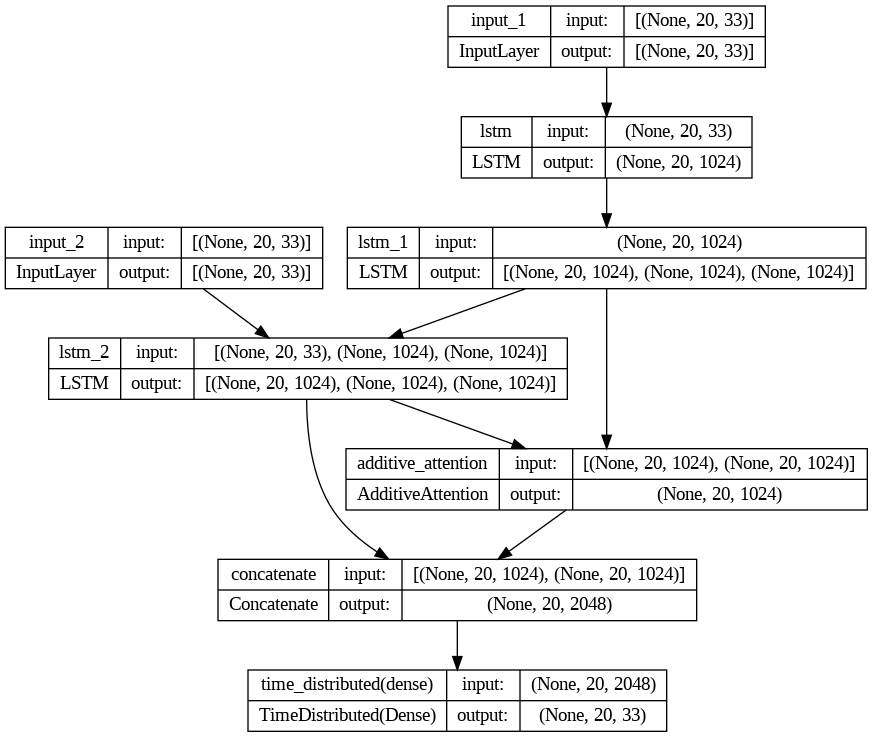

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
# from keras.callbacks import ModelCheckpoint
#
# checkpoint_path = '/content/drive/MyDrive/spellcheck/model_checkpoint{epoch:02d}.h5'
#
# checkpoint_callback = ModelCheckpoint(
#     filepath=checkpoint_path,
#     save_weights_only=False,
#     save_freq=1
# )

In [ ]:
history = model.fit([e_i[:INPUT_LENGTH], d_i[:INPUT_LENGTH]]
          , d_o[:INPUT_LENGTH]
          , epochs=EPOCH
          , batch_size=BATCH_SIZE
          , validation_data = ([val_e_i[:1000], val_d_i[:1000]], val_d_o[:1000])
          #, validation_split=0.1
          , shuffle=True
          , verbose=True
       )

Epoch 1/50
984/984 [==============================] - 52s 37ms/step - loss: 1.2541 - accuracy: 0.6329 - val_loss: 0.8130 - val_accuracy: 0.7414
Epoch 2/50
984/984 [==============================] - 36s 36ms/step - loss: 0.4521 - accuracy: 0.8599 - val_loss: 0.3912 - val_accuracy: 0.8895
Epoch 3/50
984/984 [==============================] - 36s 37ms/step - loss: 0.1664 - accuracy: 0.9497 - val_loss: 0.3406 - val_accuracy: 0.9145
Epoch 4/50
984/984 [==============================] - 36s 37ms/step - loss: 0.0844 - accuracy: 0.9756 - val_loss: 0.2761 - val_accuracy: 0.9349
Epoch 5/50
984/984 [==============================] - 36s 37ms/step - loss: 0.0536 - accuracy: 0.9846 - val_loss: 0.2776 - val_accuracy: 0.9403
Epoch 6/50
984/984 [==============================] - 36s 36ms/step - loss: 0.0367 - accuracy: 0.9893 - val_loss: 0.3061 - val_accuracy: 0.9379
Epoch 7/50
984/984 [==============================] - 36s 37ms/step - loss: 0.0289 - accuracy: 0.9916 - val_loss: 0.2776 - val_accuracy:

In [ ]:
from tensorflow.keras.models import save_model
save_model(model, "/content/drive/MyDrive/spellcheck/26-12/model.h5")

<ipython-input-49-9caa2e66e169>:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, "/content/drive/MyDrive/spellcheck/26-12/model.h5")


### Encoder Inference

In [ ]:
# encoder_inputs_ = model.inputs[0]
encoder_inputs_ = Input(shape=(SEQUENCE_LENGTH, encoding_dim))
# encoder_embedding = model.layers[1](encoder_inputs)
encoder_lstm_= model.layers[1](encoder_inputs_)
# encoder_lstm_e= model.layers[2](encoder_lstm_)
encoder_lstm1_ = model.layers[3](encoder_lstm_)
# encoder_lstm2 = model.layers[4](encoder_lstm1)
# encoder_lstm3 = model.layers[6](encoder_lstm2)
encoder_states = encoder_lstm1_[1:]
encoder_sequence = encoder_lstm1_[0]
encoder_model = Model(inputs=encoder_inputs_, outputs=[encoder_sequence, encoder_states])

In [ ]:
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 20, 33)]          0         
                                                                 
 lstm (LSTM)                 (None, 20, 1024)          4333568   
                                                                 
 lstm_1 (LSTM)               [(None, 20, 1024),        8392704   
                              (None, 1024),                      
                              (None, 1024)]                      
                                                                 
Total params: 12726272 (48.55 MB)
Trainable params: 12726272 (48.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.layers

### Decoder Inference

In [ ]:
# decoder_inputs_ = model.inputs[1]
decoder_inputs_ = Input(shape=(1, encoding_dim))

# encoder_inf_states = Input(batch_shape=(batch_size, enc_timesteps, hidden_size), name='encoder_inf_states')
# decoder_init_state = Input(batch_shape=(batch_size, hidden_size), name='decoder_init')

# decoder_embedding = model.layers[5](decoder_inputs)

encoder_output_sequence = Input(shape=(SEQUENCE_LENGTH, LATENT_DIM))
decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_lstm_ = model.layers[4](decoder_inputs_, initial_state=decoder_states_inputs)

decoder_states = [decoder_lstm_[1], decoder_lstm_[2]]

attn_inf_out = model.layers[5]([decoder_lstm_[0],encoder_output_sequence])

decoder_concat_layer = model.layers[6]([decoder_lstm_[0],attn_inf_out])
decoder_output_layer = model.layers[7](decoder_concat_layer)
decoder_model = Model(inputs=[decoder_inputs_,encoder_output_sequence, decoder_states_inputs], outputs=[decoder_output_layer]+decoder_states)

In [ ]:
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 1, 33)]              0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 1024)]               0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 1024)]               0         []                            
                                                                                                  
 lstm_2 (LSTM)               multiple                     4333568   ['input_4[0][0]',             
                                                                     'input_6[0][0]',       

In [ ]:
def predictor(input_text):
    print(input_text + "->", end="")
    input_seq = encoder_tokenizer.texts_to_sequences([input_text])[0]

    input_seq = pad_sequences([input_seq], maxlen=SEQUENCE_LENGTH, padding='post', truncating = "pre", value=encoder_tokenizer.word_index["_"])
    input_seq = tf.one_hot(input_seq, encoding_dim)
    # print(input_seq.shape)

    encoder_sequence, encoder_states = encoder_model.predict(input_seq, verbose=0)
    output_seq = []

    states = encoder_states
    target_sequence = np.zeros((1, 1, encoding_dim))
    target_sequence[0, 0, decoder_tokenizer.word_index['<']] = 1.0
    # print(target_sequence.shape)
    decoded_word = ""
    for i in range(1, SEQUENCE_LENGTH):
        output_probs, h, c = decoder_model.predict([target_sequence, encoder_sequence, states], verbose=0)
        sampled_token_idx = np.argmax(output_probs[0,0,:])
        next_word_index = reverse_word_idx[sampled_token_idx]
        decoded_word += next_word_index

        if sampled_token_idx == decoder_tokenizer.word_index['>']:
            decoded_word = decoded_word[:-1]
            break
        if sampled_token_idx == decoder_tokenizer.word_index['_']:
            decoded_word = decoded_word[:-1]
            break
        print(next_word_index, end="")

        target_sequence = np.zeros((1,1, encoding_dim))
        target_sequence[0, 0, sampled_token_idx] = 1.0

        states = [h, c]
    print()
    return decoded_word

In [ ]:
x = predictor("imzsalar") # imzalar
x = predictor("mikroorganizma") # mikroorganizma
x = predictor("yçnünde") # yönünde
x = predictor("imllet") # millet
x = predictor("yükseklil") # yükseklik
x = predictor("kerdi") # kredi
x = predictor("kampsnaylar") # kampanyalar
x = predictor("hesapalama") # hesaplama
x = predictor("ağavı") # ağacı
x = predictor("parşöen") # parşömen
x = predictor("falvı") # falcı
x = predictor("kupon") # kupon
x = predictor("kapan") # kapan
x = predictor("krpan") # kırpan
x = predictor("çaplayan") # çağlayan
x = predictor("baplama") # bağlama
x = predictor("itireafı") # itirafı
x = predictor("şekşlde") # şekilde
x = predictor("geldiğind") # geldiğinde
x = predictor("kaldğınd") # kaldığında
x = predictor("çalışıor") # çalışıyor
x = predictor("çalışr") # çalışır
x = predictor("çözebiliormuş") # çözebiliyormuş
x = predictor("gidiormuş") # gidiyormuş
x = predictor("tarf") # tarif
x = predictor("tarfler") # tarifler
x = predictor("tarfeler") # 'tarifler' or 'tarifeler'
x = predictor("piksellenemye") # piksellenmeye
x = predictor("abartmayacağjının") # abartmayacağının
x = predictor("piksle") # piksel
x = predictor("başkanığım") # başkanlığım
x = predictor("bütçenzi") # bütçenizi
x = predictor("yakınığım") # yakınlığım
x = predictor("piksellern") # piksellerin
x = predictor("samimi") # samimi
x = predictor("yssakladılar") # yasakladılar
x = predictor("twzahürat") # tezahürat
x = predictor("orman") # orman
x = predictor("kampnaylar") # kampanyalar
x = predictor("roman") # roman
x = predictor("samimiyd") # samimiydi
x = predictor("italyancxa") # italyanca

imzsalar->imzalar
mikroorganizma->mikorogranizma
yçnünde->yönünde
imllet->imlet
yükseklil->yüksekli
kerdi->kerdi
kampsnaylar->kampenyal
hesapalama->hesaplama
ağavı->ağavı
parşöen->parşen
falvı->falvı
kupon->kupon
kapan->kapan
krpan->krpan
çaplayan->çaplayan
baplama->bağlama
itireafı->itirafı
şekşlde->şeşlede
geldiğind->geldiğinde
kaldğınd->kaldığın
çalışıor->çalışıyor
çalışr->çalış
çözebiliormuş->çözebilirmuş
gidiormuş->giddormuş
tarf->tarf
tarfler->tarller
tarfeler->tarfler
piksellenemye->pikselleneyye
abartmayacağjının->abartmayacağının
piksle->pikse
başkanığım->başkanığım
bütçenzi->bütçeni
yakınığım->yakınığım
piksellern->pikseller
samimi->samimi
yssakladılar->yssakladılar
twzahürat->tezahürat
orman->orman
kampnaylar->kampanlar
roman->roman
samimiyd->samimiy
italyancxa->italyanca
